In [1]:
from __future__ import print_function, division

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import utils

In [2]:
print(torch.__version__)

0.4.0


In [3]:
batchsize=128
epoch_num=1000000
learning_rate=0.0002

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(24),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.CenterCrop(24),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='~/eunbi', train=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=batchsize, shuffle=True, num_workers=4)


testset = torchvision.datasets.CIFAR10(root='~/eunbi', train=False, transform=transform_test)
testloader = DataLoader(testset, batch_size=batchsize, shuffle=False, num_workers=4)

In [ ]:
num_classes = 10
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

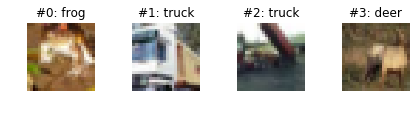

In [5]:
plt.ion()
fig = plt.figure()

for i in range(4):
    image, label = trainset[i]

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('#{}: {}'.format(i, classes[label]))
    ax.axis('off')

    image = image / 2 + 0.5     # unnormalize
    npimage = image.numpy()
    npimage = np.transpose(npimage, (1, 2, 0))
    plt.imshow(npimage)
    
image = image.unsqueeze(0)

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [7]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, stride=1, kernel_size=1)
        self.conv2 = nn.Conv2d(32, 10, kernel_size=3)
        self.conv3 = nn.Conv2d(10, 20, kernel_size=2)
        self.conv4 = nn.Conv2d(20, 40, kernel_size=3)
        self.conv5 = nn.Conv2d(40, 30, kernel_size=2)
        self.mp = nn.MaxPool2d(2, padding=1, stride=1)
        self.fc1 = nn.Linear(15870, 60)           # 500 can be changed
        self.fc2 = nn.Linear(60, 30)
        self.fc3 = nn.Linear(30, 10)
        
    def forward(self, x):
        in_size = x.size(0)
        x = self.mp(F.relu(self.conv1(x)))
        x = self.mp(F.relu(self.conv2(x)))
        x = self.mp(F.relu(self.conv3(x)))
        x = self.mp(F.relu(self.conv4(x)))
        x = self.mp(F.relu(self.conv5(x)))
        x = x.view(in_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
net = Net()

if torch.cuda.device_count() > 1:
    net= nn.DataParallel(net)

if torch.cuda.is_available():
    net.to(device)

/home/tf_study/anaconda3/envs/cifar10/lib/python3.6/site-packages/torch/nn/parallel/data_parallel.py:24: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 3 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [34]:
#Training the network


if torch.cuda.is_available():
    for epoch in range(epoch_num):  
        for i,(images, labels) in enumerate(trainloader):
            images=images.to(device)
            labels=labels.to(device)
            
            optimizer.zero_grad()

            #Forward Backward Optimize
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            if i%1000==0:
                print('Number of epochs: %d, Mini Batch order: %d' %(epoch+1,i))
                #torch.save(model,'./cifar_model.pkl')              
else:
    for epoch in range(epoch_num):  
        for i, data in enumerate(trainloader,0):
            inputs, labels = data 
            
            optimizer.zero_grad()

            #Forward Backward Optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

                # print statistics
            if i%1000==0:
                print('Number of epochs: %d, Per Batch: %d' %(epoch+1,i))
                #torch.save(model,'./cifar_model.pkl')

print('Finished Training')

Number of epochs: 1, Mini Batch order: 0
Number of epochs: 2, Mini Batch order: 0


Process Process-2975:
Process Process-2974:
Process Process-2973:
Process Process-2976:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tf_study/anaconda3/envs/cifar10/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/tf_study/anaconda3/envs/cifar10/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/tf_study/anaconda3/envs/cifar10/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/tf_study/anaconda3/envs/cifar10/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/tf_study/anaconda3/envs/cifar10/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/tf_study/anaconda3/envs/cifar10/lib/python3.6/multiprocessing/pro

KeyboardInterrupt: 

In [ ]:
#Test data

with torch.no_grad():
    num_correct = 0
    total_data = 0
    if torch.cuda.is_available():
        for images, labels in testloader:
            images=images.to(device)
            labels=labels.to(device)
            output = net(images)
            _, expected = torch.max(output.data, 1)

            total_data += labels.size(0)
            num_correct += (expected == labels).sum().item()
    else:
        for data in testloader:
            image, label=data
            output = net(image)
            _, expected = torch.max(output.data, 1)

            total_data += label.size(0)
            num_correct += (expected == label).sum().item()
        
print('Accuracy of the Data: %d %%' % (100 * num_correct / total_data))

In [48]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images=images.to(device)
        labels=labels.to(device)
        
        output = net(images).cuda()
        _, expected = torch.max(output, 1)
        c = (expected == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

RuntimeError: Expected object of type torch.FloatTensor but found type torch.cuda.FloatTensor for argument #2 'weight'